## Семинар 2 "Распознавание рукописных цифр"

ФИО: 

В этом задании мы используем нейронную сеть из предыдущего семинара для распознавания рукописных цифр. Также мы исследуем как влияет выбор нелинейности и предобработка данных на качество классификации. 

Чтобы не тратить время на подготовку данных, мы прилагаем готовый код с примером использования для получения обучающей и тестовой выборок. Для запуска скрипта вам понадобится библиотека PyTorch (инструкции по установке можно найти на сайте <a href="http://pytorch.org">pytorch.org</a>)

In [1]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
from layers import Linear, Sigmoid, NLLLoss, NeuralNetwork # Results from Seminar 1
%matplotlib inline

In [2]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

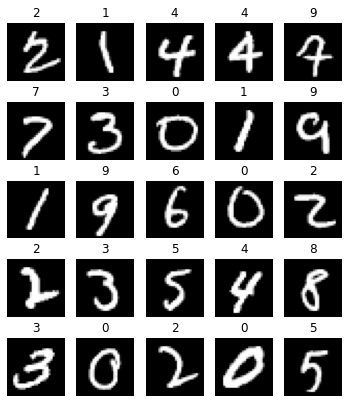

In [5]:
for X, y in train_loader:
    X = X.view(X.shape[0], -1)
    X = X.numpy()
    y = y.numpy()
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

### Часть 1: MNIST
Обучите полносвязную нейронную сеть с архитектурой 784-100-100-10 и сигмоидой в качестве нелинейности. Какую точность классификации удалось получить? Нарисуйте график сходимости на обучающей и тестовой выборках. В качестве темпа обучения (learning rate) возьмите 0.01

In [66]:
layers = [Linear(784, 100), Sigmoid(), Linear(100, 100), Sigmoid(), Linear(100, 10)]
nn = NeuralNetwork(layers)

In [67]:
loss = NLLLoss()

In [68]:
from tqdm import tqdm

In [69]:
lr = 0.01

train_loss_epochs = []
test_loss_epochs = []
train_accuracy_epochs = []
test_accuracy_epochs = []

for epoch in range(5):
    losses = np.array([])
    accuracies = np.array([])
    for X, y in tqdm(train_loader):
        X = X.view(X.shape[0], -1)
        X = X.numpy()
        y = y.numpy()

        preds = nn.forward(X)
        losses = np.append(losses, loss.forward(preds, y))
        accuracies = np.append(accuracies, (np.argmax(preds, 1)==y).mean())
        dLdpreds = loss.backward()
        nn.backward(dLdpreds)
        
        nn.step(lr)
    train_accuracy_epochs.append(np.mean(accuracies))
    train_loss_epochs.append(np.mean(losses))
    
    losses = np.array([])
    accuracies = np.array([])
    for X, y in test_loader:
        X = X.view(X.shape[0], -1)
        X = X.numpy()
        y = y.numpy()

        preds = nn.forward(X)
        losses = np.append(losses, loss.forward(preds, y))
        accuracies = np.append(accuracies, (np.argmax(preds, 1)==y).mean())
    test_accuracy_epochs.append(np.mean(accuracies))
    test_loss_epochs.append(np.mean(losses))

100%|██████████████████████████████████████| 1875/1875 [00:17<00:00, 107.62it/s]


In [70]:
import seaborn as sns

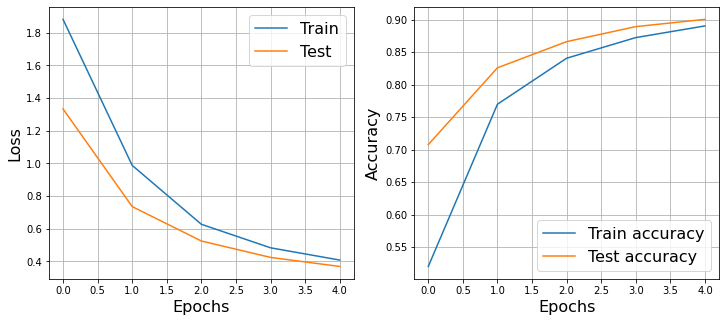

In [71]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_epochs, label='Train')
plt.plot(test_loss_epochs, label='Test')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid('on')
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_epochs, label='Train accuracy')
plt.plot(test_accuracy_epochs, label='Test accuracy')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid('on')
plt.show()

### Часть 2: Нелинейности

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

In [72]:
class ReLU:
    def __init__(self):
        pass
    
    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.mask = (X > 0).astype(float)
        return np.maximum(X, 0)
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return self.mask * dLdy
    
    def step(self, learning_rate):
        pass
    
class ELU:
    '''
    ELU(x) = x, x > 0; a*(e^x - 1), x <= 0
    '''
    
    def __init__(self, a=1):
        self.a = a

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return X * (X > 0) + self.a * (np.exp(X) - 1) * (X <= 0)
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        X = self.X
        dydX = (X > 0) + self.a * np.exp(X) * (X <= 0)
        return dLdy*dydX

    def step(self, learning_rate):
        pass    

In [73]:
layers = [Linear(784, 100), ReLU(), Linear(100, 100), ReLU(), Linear(100, 10)]
nn = NeuralNetwork(layers)

In [74]:
lr = 0.01

train_loss_epochs = []
test_loss_epochs = []
train_accuracy_epochs = []
test_accuracy_epochs = []

for epoch in range(5):
    losses = np.array([])
    accuracies = np.array([])
    for X, y in tqdm(train_loader):
        X = X.view(X.shape[0], -1)
        X = X.numpy()
        y = y.numpy()

        preds = nn.forward(X)
        losses = np.append(losses, loss.forward(preds, y))
        accuracies = np.append(accuracies, (np.argmax(preds, 1)==y).mean())
        dLdpreds = loss.backward()
        nn.backward(dLdpreds)
        
        nn.step(lr)
    train_accuracy_epochs.append(np.mean(accuracies))
    train_loss_epochs.append(np.mean(losses))
    
    losses = np.array([])
    accuracies = np.array([])
    for X, y in test_loader:
        X = X.view(X.shape[0], -1)
        X = X.numpy()
        y = y.numpy()

        preds = nn.forward(X)
        losses = np.append(losses, loss.forward(preds, y))
        accuracies = np.append(accuracies, (np.argmax(preds, 1)==y).mean())
    test_accuracy_epochs.append(np.mean(accuracies))
    test_loss_epochs.append(np.mean(losses))

100%|███████████████████████████████████████| 1875/1875 [00:28<00:00, 65.41it/s]


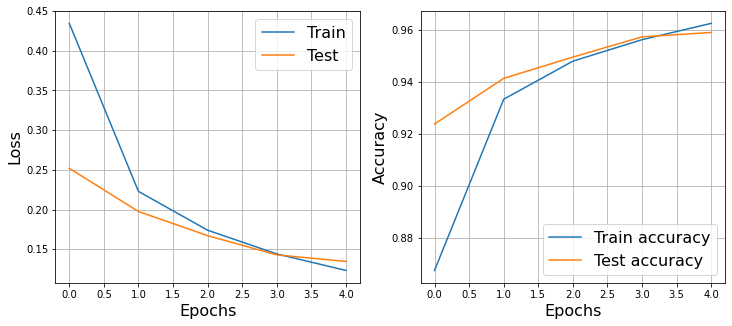

In [75]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_epochs, label='Train')
plt.plot(test_loss_epochs, label='Test')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid('on')
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_epochs, label='Train accuracy')
plt.plot(test_accuracy_epochs, label='Test accuracy')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid('on')
plt.show()

In [76]:
layers = [Linear(784, 100), ELU(), Linear(100, 100), ELU(), Linear(100, 10)]
nn = NeuralNetwork(layers)

In [77]:
lr = 0.01

train_loss_epochs = []
test_loss_epochs = []
train_accuracy_epochs = []
test_accuracy_epochs = []

for epoch in range(5):
    losses = np.array([])
    accuracies = np.array([])
    for X, y in tqdm(train_loader):
        X = X.view(X.shape[0], -1)
        X = X.numpy()
        y = y.numpy()

        preds = nn.forward(X)
        losses = np.append(losses, loss.forward(preds, y))
        accuracies = np.append(accuracies, (np.argmax(preds, 1)==y).mean())
        dLdpreds = loss.backward()
        nn.backward(dLdpreds)
        
        nn.step(lr)
    train_accuracy_epochs.append(np.mean(accuracies))
    train_loss_epochs.append(np.mean(losses))
    
    losses = np.array([])
    accuracies = np.array([])
    for X, y in test_loader:
        X = X.view(X.shape[0], -1)
        X = X.numpy()
        y = y.numpy()

        preds = nn.forward(X)
        losses = np.append(losses, loss.forward(preds, y))
        accuracies = np.append(accuracies, (np.argmax(preds, 1)==y).mean())
    test_accuracy_epochs.append(np.mean(accuracies))
    test_loss_epochs.append(np.mean(losses))

100%|███████████████████████████████████████| 1875/1875 [00:30<00:00, 62.09it/s]


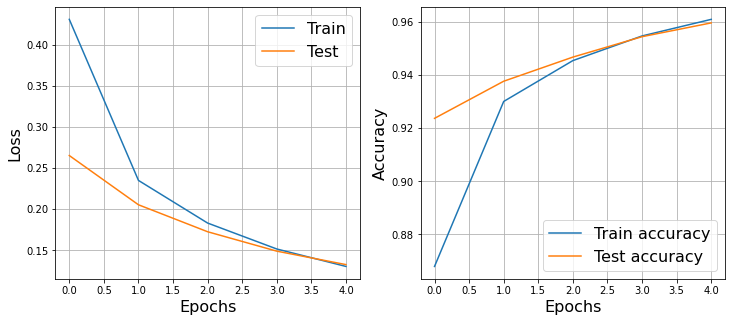

In [78]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_epochs, label='Train')
plt.plot(test_loss_epochs, label='Test')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid('on')
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_epochs, label='Train accuracy')
plt.plot(test_accuracy_epochs, label='Test accuracy')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid('on')
plt.show()

### Часть 3: Анализ ошибок
На каких объектах сеть ошибается больше всего?

In [81]:
wrong_X = []
correct_y = []
predicted_y = []
logits = []
for X, y in test_loader:
    X = X.view(X.shape[0], -1).numpy()
    y = y.numpy()
    prediction = nn.forward(X)
    prediction = np.exp(prediction)
    prediction /= prediction.sum(1, keepdims=True)
    for i in range(len(prediction)):
        if np.argmax(prediction[i]) != y[i]:
            wrong_X.append(X[i])
            correct_y.append(y[i])
            predicted_y.append(np.argmax(prediction[i]))
            logits.append(prediction[i][y[i]])
wrong_X = np.row_stack(wrong_X)
correct_y = np.row_stack(correct_y)[:, 0]
predicted_y = np.row_stack(predicted_y)[:, 0]
logits = np.row_stack(logits)[:, 0]

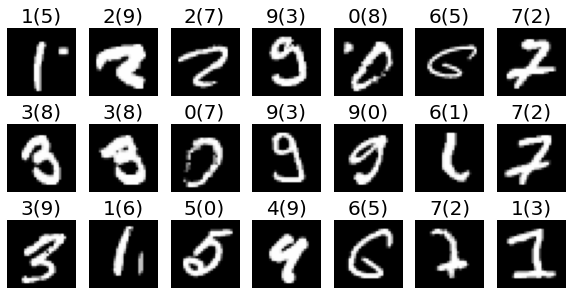

In [82]:
plt.figure(figsize=(10, 5))
order = np.argsort(logits)
for i in range(21):
    plt.subplot(3, 7, i+1)
    plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title('{}({})'.format(correct_y[order[i]], predicted_y[order[i]]), fontsize=20)
    plt.axis('off')

### HW1 (1 балл): Реализовать Tanh

In [85]:
class Tanh:
    def __init__(self):
        pass
    
    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.exp = np.exp(2*X)
        return (self.exp - 1)/(self.exp + 1)
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return dLdy * 4 * self.exp / (self.exp + 1)**2
    
    def step(self, learning_rate):
        pass

In [86]:
layers = [Linear(784, 100), Tanh(), Linear(100, 100), Tanh(), Linear(100, 10)]
nn = NeuralNetwork(layers)

In [87]:
lr = 0.01

train_loss_epochs = []
test_loss_epochs = []
train_accuracy_epochs = []
test_accuracy_epochs = []

for epoch in range(5):
    losses = np.array([])
    accuracies = np.array([])
    for X, y in tqdm(train_loader):
        X = X.view(X.shape[0], -1)
        X = X.numpy()
        y = y.numpy()

        preds = nn.forward(X)
        losses = np.append(losses, loss.forward(preds, y))
        accuracies = np.append(accuracies, (np.argmax(preds, 1)==y).mean())
        dLdpreds = loss.backward()
        nn.backward(dLdpreds)
        
        nn.step(lr)
    train_accuracy_epochs.append(np.mean(accuracies))
    train_loss_epochs.append(np.mean(losses))
    
    losses = np.array([])
    accuracies = np.array([])
    for X, y in test_loader:
        X = X.view(X.shape[0], -1)
        X = X.numpy()
        y = y.numpy()

        preds = nn.forward(X)
        losses = np.append(losses, loss.forward(preds, y))
        accuracies = np.append(accuracies, (np.argmax(preds, 1)==y).mean())
    test_accuracy_epochs.append(np.mean(accuracies))
    test_loss_epochs.append(np.mean(losses))

100%|███████████████████████████████████████| 1875/1875 [00:29<00:00, 63.20it/s]


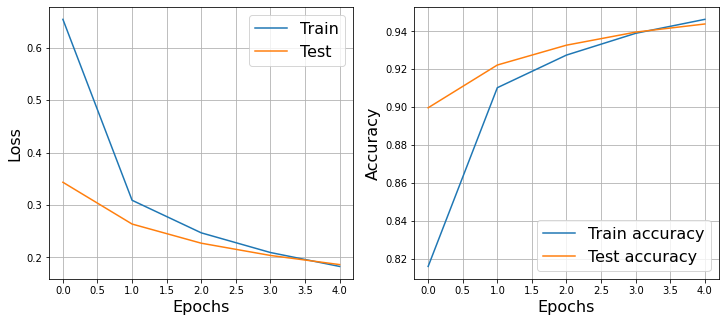

In [88]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_epochs, label='Train')
plt.plot(test_loss_epochs, label='Test')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid('on')
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_epochs, label='Train accuracy')
plt.plot(test_accuracy_epochs, label='Test accuracy')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid('on')
plt.show()

### Часть 4: Аугментация (HW, 2 балла)
* Небольшие вращения (-15, 15)
* Случайные сдвиги
* Шум

Какой прирост дают эти аугментации вместе и по отдельности

In [89]:
from scipy import ndimage
from PIL import Image

In [90]:
def rotate_func(X, angle=0):
    tmp = Image.fromarray(X.reshape(28,-1))
    return np.array(tmp.rotate(angle)).reshape(28*28,)

In [91]:
layers = [Linear(784, 100), Tanh(), Linear(100, 100), Tanh(), Linear(100, 10)]
nn = NeuralNetwork(layers)

In [92]:
lr = 0.01

train_loss_epochs = []
test_loss_epochs = []
train_accuracy_epochs = []
test_accuracy_epochs = []

for epoch in range(5):
    losses = np.array([])
    accuracies = np.array([])
    for X, y in tqdm(train_loader):
        X = X.view(X.shape[0], -1)
        X = X.numpy()
        y = y.numpy()

        preds = nn.forward(X)
        losses = np.append(losses, loss.forward(preds, y))
        accuracies = np.append(accuracies, (np.argmax(preds, 1)==y).mean())
        dLdpreds = loss.backward()
        nn.backward(dLdpreds)
        
        nn.step(lr)
        
        X_rot = np.apply_along_axis(lambda x, ang = -13 + 6 * epoch: rotate_func(x, ang), 1, X)
        preds = nn.forward(X_rot)
        losses = np.append(losses, loss.forward(preds, y))
        accuracies = np.append(accuracies, (np.argmax(preds, 1)==y).mean())
        dLdpreds = loss.backward()
        nn.backward(dLdpreds)

        nn.step(lr)
    train_accuracy_epochs.append(np.mean(accuracies))
    train_loss_epochs.append(np.mean(losses))
    
    losses = np.array([])
    accuracies = np.array([])
    for X, y in test_loader:
        X = X.view(X.shape[0], -1)
        X = X.numpy()
        y = y.numpy()

        preds = nn.forward(X)
        losses = np.append(losses, loss.forward(preds, y))
        accuracies = np.append(accuracies, (np.argmax(preds, 1)==y).mean())
    test_accuracy_epochs.append(np.mean(accuracies))
    test_loss_epochs.append(np.mean(losses))

100%|███████████████████████████████████████| 1875/1875 [00:26<00:00, 71.38it/s]


Loss упал и точность немного выросла, по сравнению с обучением без поворота.

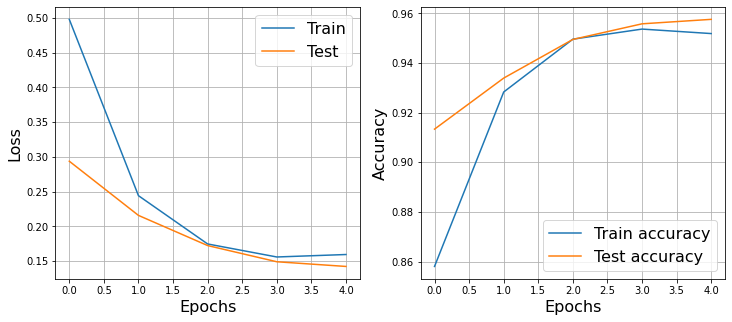

In [93]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_epochs, label='Train')
plt.plot(test_loss_epochs, label='Test')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid('on')
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_epochs, label='Train accuracy')
plt.plot(test_accuracy_epochs, label='Test accuracy')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid('on')
plt.show()

In [94]:
def move_up(X):
    tmp = X.reshape(28,28)
    for i in range(tmp.shape[0]):
        if i > 25:
            tmp[i] = np.full(tmp.shape[0], -0.42421296)
        else:
            tmp[i] = tmp[i + 2]
    return tmp.reshape(28*28,)

In [95]:
def move_right(X):
    tmp = X.reshape(28,28)
    for vec in tmp:
        vec[2:] = vec[:-2]
        vec[0] = vec[1] = -0.42421296
    return tmp.reshape(28*28,)

In [96]:
def move_left(X):
    tmp = X.reshape(28,28)
    for vec in tmp:
        vec[:-2] = vec[2:]
        vec[-2] = vec[-1] = -0.42421296
    return tmp.reshape(28*28,)

In [97]:
def move_down(X):
    tmp = X.reshape(28,28)
    for i in range(tmp.shape[0]):
        if i > 25:
            tmp[27 - i] = np.full(tmp.shape[0], -0.42421296)
        else:
            tmp[27 - i] = tmp[27 - i - 2]
    return tmp.reshape(28*28,)

In [98]:
def random_move(X):
    x_ax = np.random.randint(3)
    y_ax = np.random.randint(3)
    if (x_ax == 1):
        move_right(X)
    elif (x_ax == 2):
        move_left(X)
    
    if (y_ax == 1):
        move_up(X)
    elif (y_ax == 2):
        move_down(X)
    return X

In [104]:
layers = [Linear(784, 100), Tanh(), Linear(100, 100), Tanh(), Linear(100, 10)]
nn = NeuralNetwork(layers)
lr = 0.01

train_loss_epochs = []
test_loss_epochs = []
train_accuracy_epochs = []
test_accuracy_epochs = []

for epoch in range(5):
    losses = np.array([])
    accuracies = np.array([])
    for X, y in tqdm(train_loader):
        X = X.view(X.shape[0], -1)
        X = X.numpy()
        y = y.numpy()

        preds = nn.forward(X)
        losses = np.append(losses, loss.forward(preds, y))
        accuracies = np.append(accuracies, (np.argmax(preds, 1)==y).mean())
        dLdpreds = loss.backward()
        nn.backward(dLdpreds)
        
        nn.step(lr)
        
        X_moved = np.apply_along_axis(random_move, 1, X)
        preds = nn.forward(X_moved)
        losses = np.append(losses, loss.forward(preds, y))
        accuracies = np.append(accuracies, (np.argmax(preds, 1)==y).mean())
        dLdpreds = loss.backward()
        nn.backward(dLdpreds)

        nn.step(lr)
    train_accuracy_epochs.append(np.mean(accuracies))
    train_loss_epochs.append(np.mean(losses))
    
    losses = np.array([])
    accuracies = np.array([])
    for X, y in test_loader:
        X = X.view(X.shape[0], -1)
        X = X.numpy()
        y = y.numpy()

        preds = nn.forward(X)
        losses = np.append(losses, loss.forward(preds, y))
        accuracies = np.append(accuracies, (np.argmax(preds, 1)==y).mean())
    test_accuracy_epochs.append(np.mean(accuracies))
    test_loss_epochs.append(np.mean(losses))

100%|███████████████████████████████████████| 1875/1875 [00:45<00:00, 41.09it/s]


Случайные сдвиги дали немного лучше результат.

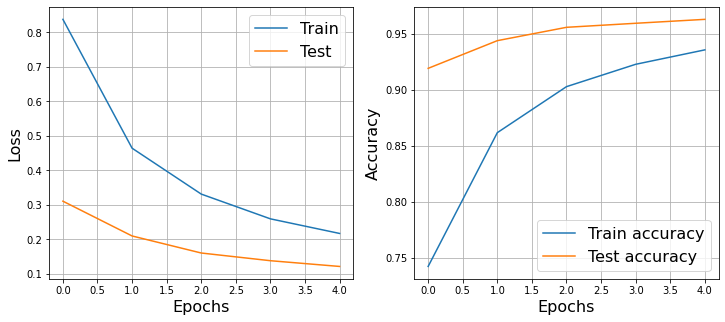

In [105]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_epochs, label='Train')
plt.plot(test_loss_epochs, label='Test')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid('on')
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_epochs, label='Train accuracy')
plt.plot(test_accuracy_epochs, label='Test accuracy')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid('on')
plt.show()

In [106]:
def noise_func(X):
    tmp = X.reshape(28, 28) + np.array(Image.effect_noise((28,28), 0.5)).astype(int) -128
    return tmp.reshape(28*28,)

In [107]:
layers = [Linear(784, 100), Tanh(), Linear(100, 100), Tanh(), Linear(100, 10)]
nn = NeuralNetwork(layers)
lr = 0.01

train_loss_epochs = []
test_loss_epochs = []
train_accuracy_epochs = []
test_accuracy_epochs = []

for epoch in range(5):
    losses = np.array([])
    accuracies = np.array([])
    for X, y in tqdm(train_loader):
        X = X.view(X.shape[0], -1)
        X = X.numpy()
        y = y.numpy()

        preds = nn.forward(X)
        losses = np.append(losses, loss.forward(preds, y))
        accuracies = np.append(accuracies, (np.argmax(preds, 1)==y).mean())
        dLdpreds = loss.backward()
        nn.backward(dLdpreds)
        
        nn.step(lr)
        
        X_noised = np.apply_along_axis(noise_func, 1, X)
        preds = nn.forward(X_noised)
        losses = np.append(losses, loss.forward(preds, y))
        accuracies = np.append(accuracies, (np.argmax(preds, 1)==y).mean())
        dLdpreds = loss.backward()
        nn.backward(dLdpreds)

        nn.step(lr)
    train_accuracy_epochs.append(np.mean(accuracies))
    train_loss_epochs.append(np.mean(losses))
    
    losses = np.array([])
    accuracies = np.array([])
    for X, y in test_loader:
        X = X.view(X.shape[0], -1)
        X = X.numpy()
        y = y.numpy()

        preds = nn.forward(X)
        losses = np.append(losses, loss.forward(preds, y))
        accuracies = np.append(accuracies, (np.argmax(preds, 1)==y).mean())
    test_accuracy_epochs.append(np.mean(accuracies))
    test_loss_epochs.append(np.mean(losses))

100%|███████████████████████████████████████| 1875/1875 [00:39<00:00, 48.00it/s]


Шум тоже дал чуть лучше результат, но хуже чем сдвиги.

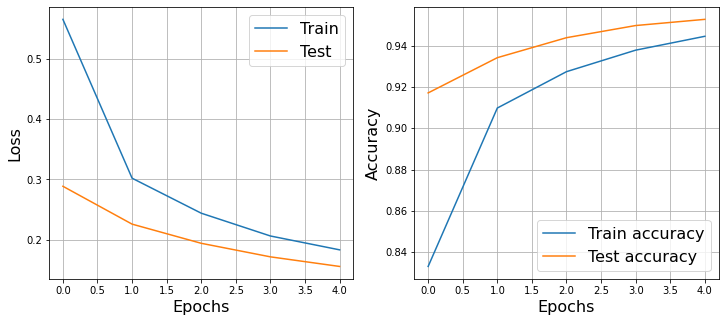

In [108]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_epochs, label='Train')
plt.plot(test_loss_epochs, label='Test')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid('on')
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_epochs, label='Train accuracy')
plt.plot(test_accuracy_epochs, label='Test accuracy')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid('on')
plt.show()

In [112]:
def random_perf(X):
    tmp = X
    if (np.random.randint(2)):
        tmp = rotate_func(X)
    if (np.random.randint(2)):
        tmp = random_move(X)
    if (np.random.randint(2)):
        tmp = noise_func(X)
    return tmp

In [114]:
layers = [Linear(784, 100), Tanh(), Linear(100, 100), Tanh(), Linear(100, 10)]
nn = NeuralNetwork(layers)
lr = 0.01

train_loss_epochs = []
test_loss_epochs = []
train_accuracy_epochs = []
test_accuracy_epochs = []

for epoch in range(5):
    losses = np.array([])
    accuracies = np.array([])
    for X, y in tqdm(train_loader):
        X = X.view(X.shape[0], -1)
        X = X.numpy()
        y = y.numpy()

        preds = nn.forward(X)
        losses = np.append(losses, loss.forward(preds, y))
        accuracies = np.append(accuracies, (np.argmax(preds, 1)==y).mean())
        dLdpreds = loss.backward()
        nn.backward(dLdpreds)
        
        nn.step(lr)
        
        X_perf = np.apply_along_axis(random_perf, 1, X)
        preds = nn.forward(X_perf)
        losses = np.append(losses, loss.forward(preds, y))
        accuracies = np.append(accuracies, (np.argmax(preds, 1)==y).mean())
        dLdpreds = loss.backward()
        nn.backward(dLdpreds)
        
        nn.step(lr)
        
    train_accuracy_epochs.append(np.mean(accuracies))
    train_loss_epochs.append(np.mean(losses))
    
    losses = np.array([])
    accuracies = np.array([])
    for X, y in test_loader:
        X = X.view(X.shape[0], -1)
        X = X.numpy()
        y = y.numpy()

        preds = nn.forward(X)
        losses = np.append(losses, loss.forward(preds, y))
        accuracies = np.append(accuracies, (np.argmax(preds, 1)==y).mean())
    test_accuracy_epochs.append(np.mean(accuracies))
    test_loss_epochs.append(np.mean(losses))

100%|███████████████████████████████████████| 1875/1875 [00:32<00:00, 57.27it/s]


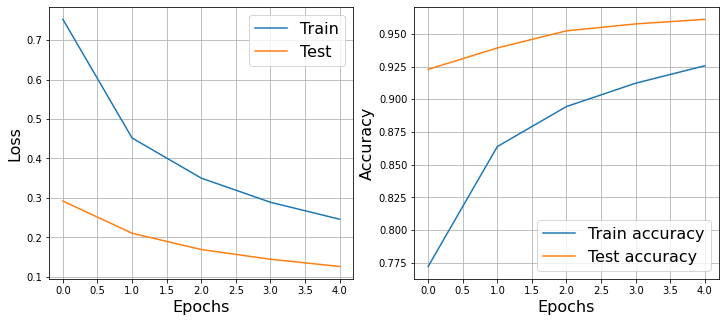

In [115]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_epochs, label='Train')
plt.plot(test_loss_epochs, label='Test')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid('on')
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_epochs, label='Train accuracy')
plt.plot(test_accuracy_epochs, label='Test accuracy')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid('on')
plt.show()

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

In [116]:
layers = [Linear(784, 100), ReLU(), Linear(100, 100), ReLU(), Linear(100, 10)]
nn = NeuralNetwork(layers)
lr = 0.01

train_loss_epochs = []
test_loss_epochs = []
train_accuracy_epochs = []
test_accuracy_epochs = []

for epoch in range(5):
    losses = np.array([])
    accuracies = np.array([])
    for X, y in tqdm(train_loader):
        X = X.view(X.shape[0], -1)
        X = X.numpy()
        y = y.numpy()

        preds = nn.forward(X)
        losses = np.append(losses, loss.forward(preds, y))
        accuracies = np.append(accuracies, (np.argmax(preds, 1)==y).mean())
        dLdpreds = loss.backward()
        nn.backward(dLdpreds)
        
        nn.step(lr)
        
        X_perf = np.apply_along_axis(random_perf, 1, X)
        preds = nn.forward(X_perf)
        losses = np.append(losses, loss.forward(preds, y))
        accuracies = np.append(accuracies, (np.argmax(preds, 1)==y).mean())
        dLdpreds = loss.backward()
        nn.backward(dLdpreds)
        
        nn.step(lr)
        
    train_accuracy_epochs.append(np.mean(accuracies))
    train_loss_epochs.append(np.mean(losses))
    
    losses = np.array([])
    accuracies = np.array([])
    for X, y in test_loader:
        X = X.view(X.shape[0], -1)
        X = X.numpy()
        y = y.numpy()

        preds = nn.forward(X)
        losses = np.append(losses, loss.forward(preds, y))
        accuracies = np.append(accuracies, (np.argmax(preds, 1)==y).mean())
    test_accuracy_epochs.append(np.mean(accuracies))
    test_loss_epochs.append(np.mean(losses))

100%|███████████████████████████████████████| 1875/1875 [00:29<00:00, 62.82it/s]


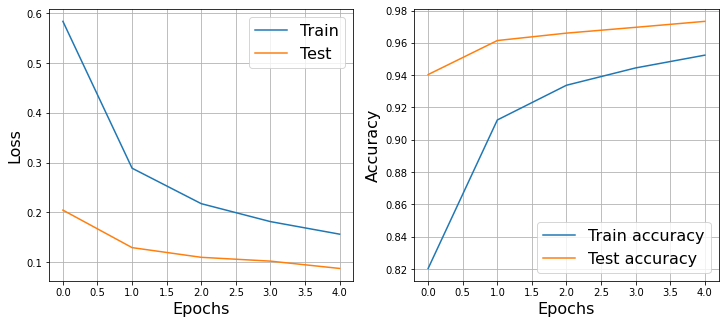

In [117]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_epochs, label='Train')
plt.plot(test_loss_epochs, label='Test')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid('on')
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_epochs, label='Train accuracy')
plt.plot(test_accuracy_epochs, label='Test accuracy')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid('on')
plt.show()

In [118]:
layers = [Linear(784, 100), ELU(), Linear(100, 100), ELU(), Linear(100, 10)]
nn = NeuralNetwork(layers)
lr = 0.01

train_loss_epochs = []
test_loss_epochs = []
train_accuracy_epochs = []
test_accuracy_epochs = []

for epoch in range(5):
    losses = np.array([])
    accuracies = np.array([])
    for X, y in tqdm(train_loader):
        X = X.view(X.shape[0], -1)
        X = X.numpy()
        y = y.numpy()

        preds = nn.forward(X)
        losses = np.append(losses, loss.forward(preds, y))
        accuracies = np.append(accuracies, (np.argmax(preds, 1)==y).mean())
        dLdpreds = loss.backward()
        nn.backward(dLdpreds)
        
        nn.step(lr)
        
        X_perf = np.apply_along_axis(random_perf, 1, X)
        preds = nn.forward(X_perf)
        losses = np.append(losses, loss.forward(preds, y))
        accuracies = np.append(accuracies, (np.argmax(preds, 1)==y).mean())
        dLdpreds = loss.backward()
        nn.backward(dLdpreds)
        
        nn.step(lr)
        
    train_accuracy_epochs.append(np.mean(accuracies))
    train_loss_epochs.append(np.mean(losses))
    
    losses = np.array([])
    accuracies = np.array([])
    for X, y in test_loader:
        X = X.view(X.shape[0], -1)
        X = X.numpy()
        y = y.numpy()

        preds = nn.forward(X)
        losses = np.append(losses, loss.forward(preds, y))
        accuracies = np.append(accuracies, (np.argmax(preds, 1)==y).mean())
    test_accuracy_epochs.append(np.mean(accuracies))
    test_loss_epochs.append(np.mean(losses))

100%|███████████████████████████████████████| 1875/1875 [00:39<00:00, 47.17it/s]


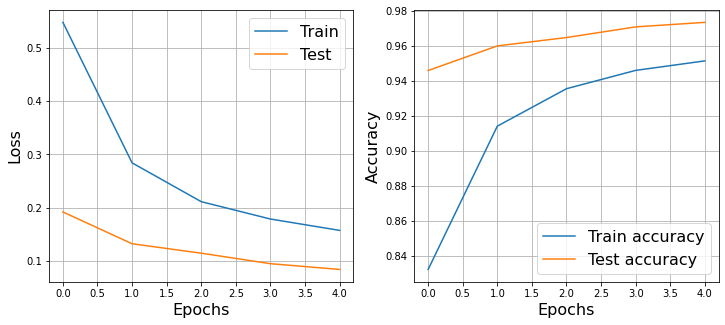

In [119]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_epochs, label='Train')
plt.plot(test_loss_epochs, label='Test')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid('on')
plt.subplot(1, 2, 2)
plt.plot(train_accuracy_epochs, label='Train accuracy')
plt.plot(test_accuracy_epochs, label='Test accuracy')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid('on')
plt.show()

### Часть 5: Выводы
Опишите полученные результаты: как влияют выбор нелинейности и предобработка данных на скорость сходимости и итоговое качество?

Я рассмотрел такие нелинейности, как Tanh, ReLU и ELU. В зависимости от выбора нелинейности, точность улучшалась, в нашем случае ReLU и ELU давали примерно одинаковые результаты, и лучше, чем Tanh, а тем более сигмоида. Аугментация тоже дает прирост к качеству, лучше всего себя показали случайные сдвиги. Сходимость к минимуму у Loss увеличивается при выборе правильной функции активации и аугментации, а итоговое качество выше.